#***LSTM***

#8:2

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Đọc dữ liệu từ file CSV
file_path = '/content/BNB.csv'
data = pd.read_csv(file_path)

In [3]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 8:2
train_size = int(len(scaled_prices) * 0.8)
test_size = len(scaled_prices) - train_size

train, test = scaled_prices[0:train_size], scaled_prices[train_size:]

print(f'train: {train_size}')
print(f'test: {test_size}')

train: 1523
test: 381


In [4]:
# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# Dự đoán trên tập test
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Đánh giá mô hình
mse = mean_squared_error(y_test[0], test_predict[:,0])
mae = mean_absolute_error(y_test[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test[0] - test_predict[:,0]) / y_test[0])) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Epoch 1/50
1463/1463 - 53s - loss: 0.0037 - 53s/epoch - 37ms/step
Epoch 2/50
1463/1463 - 56s - loss: 0.0014 - 56s/epoch - 38ms/step
Epoch 3/50
1463/1463 - 65s - loss: 0.0010 - 65s/epoch - 45ms/step
Epoch 4/50
1463/1463 - 55s - loss: 8.6840e-04 - 55s/epoch - 37ms/step
Epoch 5/50
1463/1463 - 43s - loss: 7.2126e-04 - 43s/epoch - 29ms/step
Epoch 6/50
1463/1463 - 47s - loss: 8.2127e-04 - 47s/epoch - 32ms/step
Epoch 7/50
1463/1463 - 44s - loss: 7.2459e-04 - 44s/epoch - 30ms/step
Epoch 8/50
1463/1463 - 46s - loss: 7.2420e-04 - 46s/epoch - 32ms/step
Epoch 9/50
1463/1463 - 42s - loss: 7.7005e-04 - 42s/epoch - 29ms/step
Epoch 10/50
1463/1463 - 45s - loss: 6.8749e-04 - 45s/epoch - 31ms/step
Epoch 11/50
1463/1463 - 43s - loss: 6.4563e-04 - 43s/epoch - 29ms/step
Epoch 12/50
1463/1463 - 43s - loss: 6.6078e-04 - 43s/epoch - 29ms/step
Epoch 13/50
1463/1463 - 43s - loss: 6.3706e-04 - 43s/epoch - 29ms/step
Epoch 14/50
1463/1463 - 43s - loss: 6.8626e-04 - 43s/epoch - 29ms/step
Epoch 15/50
1463/1463 - 44s

In [6]:
# Dự đoán tương lai
def predict_future_lstm(model, initial_data, look_back, future_steps):
    predictions = []
    current_input = initial_data[-look_back:]

    for _ in range(future_steps):
        current_input = current_input.reshape((1, look_back, 1))
        next_pred = model.predict(current_input, verbose=0)
        predictions.append(next_pred[0, 0])
        current_input = np.concatenate((current_input[:, 1:, :], next_pred.reshape(1, 1, 1)), axis=1)

    return np.array(predictions)

# Dự đoán 30, 60 và 90 ngày
next_30_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 30)
next_60_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 60)
next_90_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 90)

# Biến đổi ngược dữ liệu để đưa về dạng giá trị ban đầu
next_30_days_actual = scaler.inverse_transform(next_30_days.reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(next_60_days.reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(next_90_days.reshape(-1, 1))

# In ra các dự đoán cho 30, 60 và 90 ngày tiếp theo
print("Predicted Prices for the Next 30 Days:")
print(next_30_days_actual.flatten())

print("\nPredicted Prices for the Next 60 Days:")
print(next_60_days_actual.flatten())

print("\nPredicted Prices for the Next 90 Days:")
print(next_90_days_actual.flatten())

Predicted Prices for the Next 30 Days:
[572.5066  573.58234 574.5169  575.73016 576.92255 578.137   579.41656
 580.7905  582.25684 583.78845 585.3468  586.893   588.3958  589.8333
 591.19196 592.4644  593.6474  594.73975 595.74243 596.65717 597.4873
 598.23676 598.9102  599.51306 600.0507  600.52893 600.953   601.3281
 601.65967 601.95184]

Predicted Prices for the Next 60 Days:
[572.5066  573.58234 574.5169  575.73016 576.92255 578.137   579.41656
 580.7905  582.25684 583.78845 585.3468  586.893   588.3958  589.8333
 591.19196 592.4644  593.6474  594.73975 595.74243 596.65717 597.4873
 598.23676 598.9102  599.51306 600.0507  600.52893 600.953   601.3281
 601.65967 601.95184 602.20917 602.4356  602.6346  602.8094  602.96295
 603.0978  603.2163  603.3206  603.4122  603.49286 603.56396 603.6267
 603.682   603.7309  603.77405 603.8125  603.8465  603.8766  603.90326
 603.9271  603.94824 603.96716 603.984   603.999   604.0123  604.02423
 604.0348  604.0442  604.0526  604.06006]

Predicted P

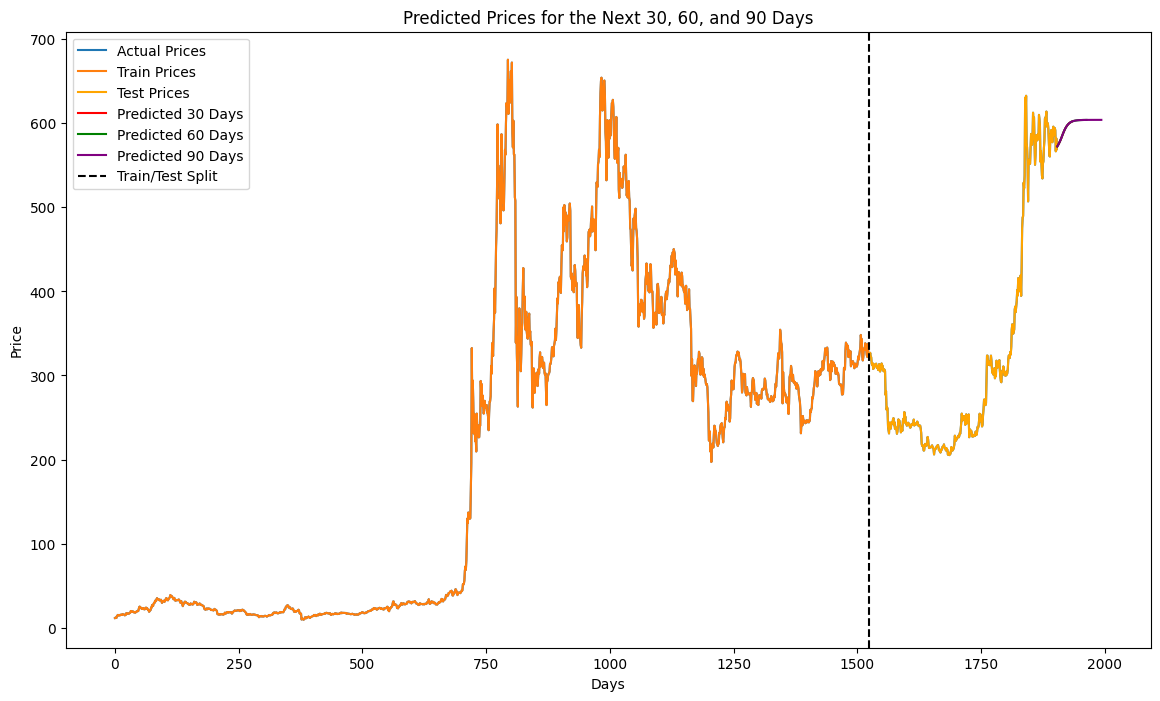

In [7]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()

#7:3

In [8]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 7:3
train_size = int(len(scaled_prices) * 0.7)
test_size = len(scaled_prices) - train_size

train, test = scaled_prices[0:train_size], scaled_prices[train_size:]

print(f'train: {train_size}')
print(f'test: {test_size}')

train: 1332
test: 572


In [9]:
# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# Dự đoán trên tập test
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Đánh giá mô hình
mse = mean_squared_error(y_test[0], test_predict[:,0])
mae = mean_absolute_error(y_test[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test[0] - test_predict[:,0]) / y_test[0])) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Epoch 1/50
1272/1272 - 54s - loss: 0.0051 - 54s/epoch - 42ms/step
Epoch 2/50
1272/1272 - 39s - loss: 0.0018 - 39s/epoch - 31ms/step
Epoch 3/50
1272/1272 - 39s - loss: 0.0013 - 39s/epoch - 30ms/step
Epoch 4/50
1272/1272 - 38s - loss: 9.8710e-04 - 38s/epoch - 30ms/step
Epoch 5/50
1272/1272 - 40s - loss: 9.3336e-04 - 40s/epoch - 31ms/step
Epoch 6/50
1272/1272 - 39s - loss: 8.2886e-04 - 39s/epoch - 31ms/step
Epoch 7/50
1272/1272 - 39s - loss: 7.8069e-04 - 39s/epoch - 31ms/step
Epoch 8/50
1272/1272 - 38s - loss: 9.2284e-04 - 38s/epoch - 30ms/step
Epoch 9/50
1272/1272 - 39s - loss: 7.3180e-04 - 39s/epoch - 31ms/step
Epoch 10/50
1272/1272 - 39s - loss: 6.9630e-04 - 39s/epoch - 31ms/step
Epoch 11/50
1272/1272 - 39s - loss: 7.2415e-04 - 39s/epoch - 31ms/step
Epoch 12/50
1272/1272 - 39s - loss: 8.0056e-04 - 39s/epoch - 31ms/step
Epoch 13/50
1272/1272 - 37s - loss: 7.6231e-04 - 37s/epoch - 29ms/step
Epoch 14/50
1272/1272 - 40s - loss: 7.0651e-04 - 40s/epoch - 32ms/step
Epoch 15/50
1272/1272 - 39s

In [10]:
# Dự đoán tương lai
def predict_future_lstm(model, initial_data, look_back, future_steps):
    predictions = []
    current_input = initial_data[-look_back:]

    for _ in range(future_steps):
        current_input = current_input.reshape((1, look_back, 1))
        next_pred = model.predict(current_input, verbose=0)
        predictions.append(next_pred[0, 0])
        current_input = np.concatenate((current_input[:, 1:, :], next_pred.reshape(1, 1, 1)), axis=1)

    return np.array(predictions)

# Dự đoán 30, 60 và 90 ngày
next_30_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 30)
next_60_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 60)
next_90_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 90)

# Biến đổi ngược dữ liệu để đưa về dạng giá trị ban đầu
next_30_days_actual = scaler.inverse_transform(next_30_days.reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(next_60_days.reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(next_90_days.reshape(-1, 1))

# In ra các dự đoán cho 30, 60 và 90 ngày tiếp theo
print("Predicted Prices for the Next 30 Days:")
print(next_30_days_actual.flatten())

print("\nPredicted Prices for the Next 60 Days:")
print(next_60_days_actual.flatten())

print("\nPredicted Prices for the Next 90 Days:")
print(next_90_days_actual.flatten())

Predicted Prices for the Next 30 Days:
[552.9539  539.3128  525.53107 512.1264  499.48285 487.74835 476.9329
 466.9487  457.6616  448.9388  440.68085 432.83273 425.37686 418.31595
 411.65436 405.3862  399.49036 393.93335 388.67578 383.6799  378.9142
 374.35538 369.98712 365.7972  361.7751  357.90967 354.18906 350.60074
 347.13272 343.77448]

Predicted Prices for the Next 60 Days:
[552.9539  539.3128  525.53107 512.1264  499.48285 487.74835 476.9329
 466.9487  457.6616  448.9388  440.68085 432.83273 425.37686 418.31595
 411.65436 405.3862  399.49036 393.93335 388.67578 383.6799  378.9142
 374.35538 369.98712 365.7972  361.7751  357.90967 354.18906 350.60074
 347.13272 343.77448 340.51715 337.35382 334.27856 331.28632 328.37225
 325.53168 322.76    320.0529  317.40637 314.81696 312.28168 309.7978
 307.36285 304.9746  302.63083 300.3294  298.0684  295.8459  293.66028
 291.50998 289.3936  287.3098  285.2574  283.23508 281.24185 279.2765
 277.33813 275.42575 273.53854 271.67563]

Predicted 

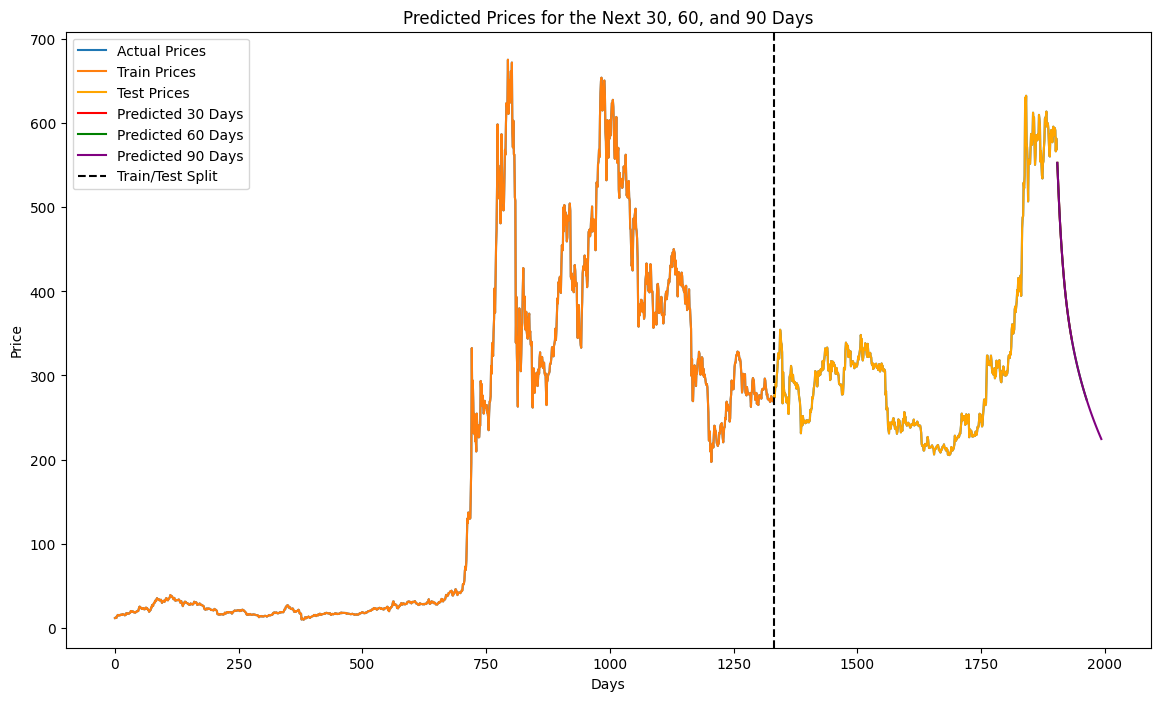

In [11]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()

#6:4

In [12]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 6:4
train_size = int(len(scaled_prices) * 0.6)
test_size = len(scaled_prices) - train_size

train, test = scaled_prices[0:train_size], scaled_prices[train_size:]

print(f'train: {train_size}')
print(f'test: {test_size}')

train: 1142
test: 762


In [13]:
# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# Dự đoán trên tập test
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Đánh giá mô hình
mse = mean_squared_error(y_test[0], test_predict[:,0])
mae = mean_absolute_error(y_test[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test[0] - test_predict[:,0]) / y_test[0])) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Epoch 1/50
1082/1082 - 37s - loss: 0.0062 - 37s/epoch - 34ms/step
Epoch 2/50
1082/1082 - 33s - loss: 0.0024 - 33s/epoch - 31ms/step
Epoch 3/50
1082/1082 - 32s - loss: 0.0015 - 32s/epoch - 30ms/step
Epoch 4/50
1082/1082 - 32s - loss: 0.0014 - 32s/epoch - 30ms/step
Epoch 5/50
1082/1082 - 33s - loss: 9.5080e-04 - 33s/epoch - 30ms/step
Epoch 6/50
1082/1082 - 32s - loss: 9.4402e-04 - 32s/epoch - 29ms/step
Epoch 7/50
1082/1082 - 33s - loss: 9.3096e-04 - 33s/epoch - 31ms/step
Epoch 8/50
1082/1082 - 32s - loss: 9.0994e-04 - 32s/epoch - 29ms/step
Epoch 9/50
1082/1082 - 33s - loss: 8.8389e-04 - 33s/epoch - 31ms/step
Epoch 10/50
1082/1082 - 31s - loss: 9.2020e-04 - 31s/epoch - 29ms/step
Epoch 11/50
1082/1082 - 31s - loss: 8.3952e-04 - 31s/epoch - 29ms/step
Epoch 12/50
1082/1082 - 33s - loss: 8.4321e-04 - 33s/epoch - 31ms/step
Epoch 13/50
1082/1082 - 33s - loss: 7.6990e-04 - 33s/epoch - 31ms/step
Epoch 14/50
1082/1082 - 31s - loss: 7.7077e-04 - 31s/epoch - 29ms/step
Epoch 15/50
1082/1082 - 31s - l

In [14]:
# Dự đoán tương lai
def predict_future_lstm(model, initial_data, look_back, future_steps):
    predictions = []
    current_input = initial_data[-look_back:]

    for _ in range(future_steps):
        current_input = current_input.reshape((1, look_back, 1))
        next_pred = model.predict(current_input, verbose=0)
        predictions.append(next_pred[0, 0])
        current_input = np.concatenate((current_input[:, 1:, :], next_pred.reshape(1, 1, 1)), axis=1)

    return np.array(predictions)

# Dự đoán 30, 60 và 90 ngày
next_30_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 30)
next_60_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 60)
next_90_days = predict_future_lstm(model, scaled_prices[-look_back:], look_back, 90)

# Biến đổi ngược dữ liệu để đưa về dạng giá trị ban đầu
next_30_days_actual = scaler.inverse_transform(next_30_days.reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(next_60_days.reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(next_90_days.reshape(-1, 1))

# In ra các dự đoán cho 30, 60 và 90 ngày tiếp theo
print("Predicted Prices for the Next 30 Days:")
print(next_30_days_actual.flatten())

print("\nPredicted Prices for the Next 60 Days:")
print(next_60_days_actual.flatten())

print("\nPredicted Prices for the Next 90 Days:")
print(next_90_days_actual.flatten())

Predicted Prices for the Next 30 Days:
[579.7891  587.43274 594.152   601.6263  608.8776  615.8359  622.5001
 628.88055 634.92975 640.567   645.71497 650.3219  654.36774 657.8581
 660.816   663.2741  665.271   666.8482  668.04926 668.91785 669.4977
 669.83105 669.95764 669.91547 669.7386  669.4581  669.10126 668.69244
 668.2521  667.798  ]

Predicted Prices for the Next 60 Days:
[579.7891  587.43274 594.152   601.6263  608.8776  615.8359  622.5001
 628.88055 634.92975 640.567   645.71497 650.3219  654.36774 657.8581
 660.816   663.2741  665.271   666.8482  668.04926 668.91785 669.4977
 669.83105 669.95764 669.91547 669.7386  669.4581  669.10126 668.69244
 668.2521  667.798   667.3444  666.903   666.4831  666.0912  665.7322
 665.4091  665.1233  664.8751  664.6639  664.4878  664.34467 664.23193
 664.1466  664.0857  664.04614 664.02484 664.0187  664.02515 664.04144
 664.06525 664.09467 664.1276  664.1627  664.19867 664.2344  664.2689
 664.30164 664.3321  664.35974 664.38446]

Predicted Pr

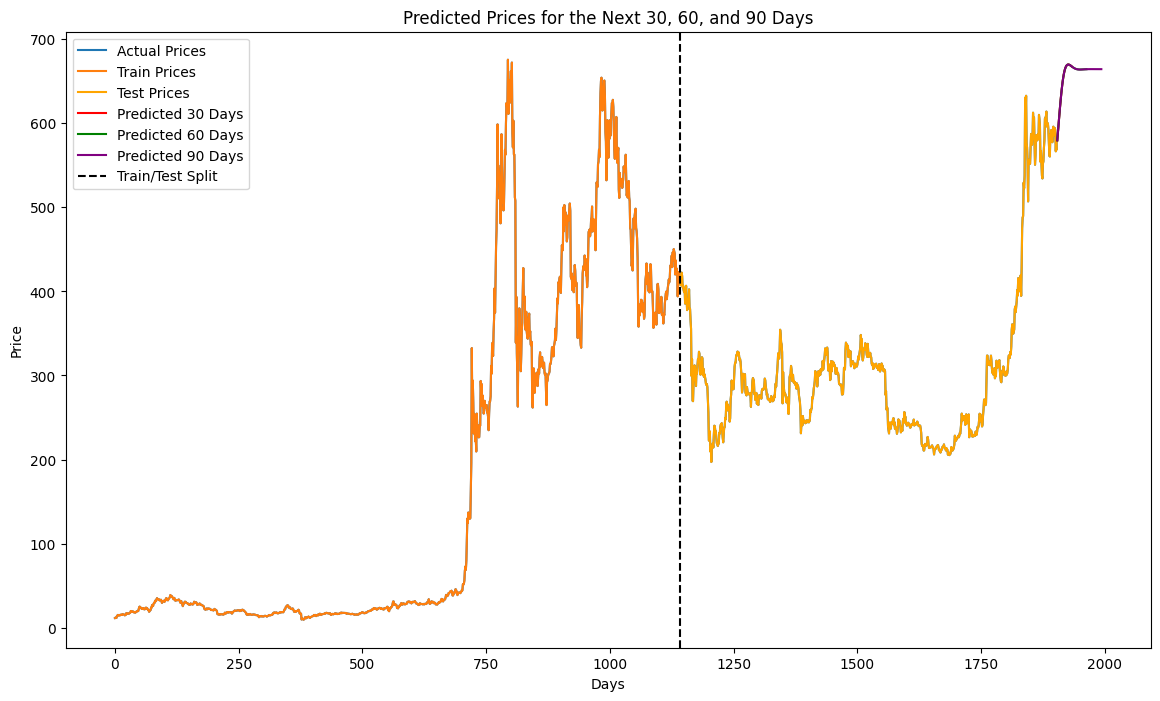

In [15]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()